# Template for analyzing the CLM5-PPE
- Updated July 8, 2021
- Daniel Kennedy, djk2120@ucar.edu

In [12]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm

## spin up some extra cores on CASPER

In [17]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='4:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    client = Client(cluster)
    return cluster, client

In [18]:
#only run once
cluster, client = get_ClusterClient()
cluster.scale(20)

/glade/work/djk2120/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41269 instead
  http_address["port"], self.http_server.port


In [25]:
#note that you should eventually see your workers in the output here
# you can rerun this cell, to check that the job made it through the queue
client

Client Scheduler: tcp://10.12.206.54:38166 Dashboard: https://https://jupyterhub.hpc.ucar.edu/stable/user/djk2120/proxy/{port}/status,Cluster Workers: 20 Cores: 20 Memory: 500.00 GB


## A few useful functions

In [3]:
def get_params(keys,paramkey):
    params=[]
    minmaxs=[]
    for key in keys:
        ix     = paramkey.key==key
        params.append(paramkey.param[ix].values[0])
        minmaxs.append(paramkey.minmax[ix].values[0])
    return params,minmaxs

In [4]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [75]:
def param_effect(da,p,uniques,cf):
    nyrs=10

    x0      = (cf*month_wts(nyrs)*la*da).compute()
    x1      = 1/nyrs*x0.sum(dim='time').compute()
    
    mean    = x1.sum(dim='gridcell').compute()
    iav     = x0.sum(dim='gridcell').groupby('time.year').sum().std(dim='year').compute()
    xdefs   = np.array([mean.sel(ens=0).values,iav.sel(ens=0).values])

    
    effect_on_mean =[]
    effect_on_iav  =[]
    dxs            =[]
    for param in uniques:
        print(param)
        ix    = p==param
        xvals = x1.isel(ens=ix)
        mean2 = mean.isel(ens=ix)
        iav2  = iav.isel(ens=ix)
        
        if len(mean2)==2:
            #has min and max
            effect_on_mean.append(abs(mean2[0]-mean2[1]).values)
            effect_on_iav.append(abs(iav2[0]-iav2[1]).values)
            dxs.append(xvals[:,0]-xvals[:,1])
        else:
            #only has one or the other, sub in default x[0]
            effect_on_mean.append(abs(mean[0]-mean2[0]).values)
            effect_on_iav.append(abs(iav[0]-iav2[0]).values)
            dxs.append(x1.sel(ens=0)-xvals[:,0])

    dx      = xr.concat(dxs,dim='ens')
    r2      = np.corrcoef(dx)**2
    r2[np.isnan(r2)]=1   #this is to correct for BFBs
    spatial = r2.sum(axis=0)
            
    effect_on_mean = np.array(effect_on_mean)
    effect_on_iav  = np.array(effect_on_iav)

    return effect_on_mean,effect_on_iav,spatial,xdefs

In [64]:
def get_map(da):
    '''
    Regrid from sparsegrid to standard lat/lon
    
    Better to do any dimension-reducing math before calling this function. 
    Could otherwise be pretty slow...
    '''
    
    #ACCESS the sparsegrid info
    thedir  = '/glade/u/home/forrest/ppe_representativeness/output_v4/'
    thefile = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
    sg = xr.open_dataset(thedir+thefile)
    
    #DIAGNOSE the shape of the output map
    newshape = []
    coords=[]
    #  grab any dimensions that arent "gridcell" from da
    for coord,nx in zip(da.coords,da.shape):
        if nx!=400:
            newshape.append(nx)
            coords.append((coord,da[coord]))
    #  grab lat/lon from sg
    for coord in ['lat','lon']:
        nx = len(sg[coord])
        newshape.append(nx)
        coords.append((coord,sg[coord]))

    #INSTANTIATE the outgoing array
    array = np.zeros(newshape)+np.nan
    nd    = len(array.shape)
    
    #FILL the array
    ds = xr.open_dataset('/glade/scratch/djk2120/PPEn11/hist/CTL2010/PPEn11_CTL2010_OAAT0399.clm2.h0.2005-02-01-00000.nc')
    for i in range(400):
        lat=ds.grid1d_lat[i]
        lon=ds.grid1d_lon[i]
        cc = sg.rcent.sel(lat=lat,lon=lon,method='nearest')
        ix = sg.cclass==cc
        
        
        if nd==2:
            array[ix]=da.isel(gridcell=i)
        else:
            nx = ix.sum().values
            array[:,ix]=np.tile(da.isel(gridcell=i).values[:,np.newaxis],[1,nx])
    
    #OUTPUT as DataArray
    da_map = xr.DataArray(array,name=da.name,coords=coords)
    da_map.attrs=da.attrs

    return da_map

In [14]:
def get_ensemble(name,data_vars,htape,paramkey):
    '''
    Returns a dataset comprising the given ensemble
    name  = 'CTL2020' or 'C285' or 'AF1905'
    data_vars, e.g. ['GPP','HR','AR']
    htape, e.g. 'h0' 0/1/2/3/4/5/7 available
    '''
    
    #define the directory structure
    topdir     = '/glade/scratch/djk2120/PPEn11/hist/' 
    thisdir    = topdir+name+'/'
    files      = sorted(glob.glob(thisdir+'*'+htape+'*'))

    def preprocess(ds):
        return ds[data_vars]

    #read in the dataset
    ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',parallel=True,preprocess=preprocess)

    #fix up time dimension
    ds['time'] = xr.cftime_range(str(2005),periods=120,freq='MS') #fix time bug

    #append some info about key/param/minmax
    keys           = [file.split('_')[2].split('.')[0] for file in files]
    params,minmaxs = get_params(keys,paramkey) 
    ds['key']    = xr.DataArray(keys,dims='ens')
    ds['param']  = xr.DataArray(params,dims='ens')
    ds['minmax'] = xr.DataArray(minmaxs,dims='ens')
    
    return ds

In [13]:
#fetch the paraminfo
csv = '/glade/scratch/djk2120/PPEn11/OAAT_jul2020.csv' 
paramkey = pd.read_csv(csv)

#fetch the sparsegrid landarea
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2

## START HERE:

In [26]:
name = 'C285'
data_vars = ['GPP','HR','AR']
htape = 'h0'
ds = get_ensemble(name,data_vars,htape,paramkey)

In [27]:
ds.GPP

<xarray.DataArray 'GPP' (ens: 373, time: 120, gridcell: 400)>
dask.array<concatenate, shape=(373, 120, 400), dtype=float32, chunksize=(1, 120, 400), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
Dimensions without coordinates: ens, gridcell
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean

In [28]:
#use the landarea vector and month_wts to calculate average annual GPP
cf = 24*60*60*1e-9  #PgC
gpp_glob     = (la*ds.GPP).sum(dim='gridcell')
gpp_glob_ann = cf*(month_wts(10)*gpp_glob).groupby('time.year').sum()
gpp_avg      = gpp_glob_ann.mean(dim='year').compute()

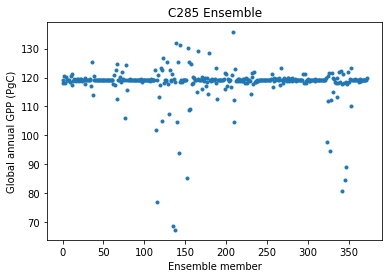

In [29]:
gpp_avg.plot.line('.')
plt.xlabel('Ensemble member')
plt.ylabel('Global annual GPP (PgC)')
plt.title('C285 Ensemble');

In [40]:
#which perturbations yield the bottom 10 lowest GPP?
print('LOW GPP:')
for i in np.argsort(gpp_avg)[:10]:
    p = str(ds.param[i].values)
    m = str(ds.minmax[i].values)
    print('   '+p+'-'+m)

LOW GPP:
   jmaxb0-min
   lmrse-max
   medlynintercept-max
   lmrhd-min
   vcmaxse_sf-max
   kmax-min
   jmaxse_sf-max
   wc2wjb0-min
   tpuha-max
   vcmaxha-max


### look at the map of jmaxb0-min

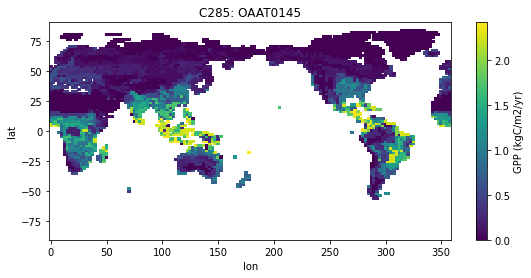

In [71]:
#find the given member
ix  = np.logical_and(ds.param=='jmaxb0',ds.minmax=='min')
da  = ds.GPP.isel(ens=ix) 

#calc annual gpp
nyrs = 10
cf   = 24*60*60/nyrs/1000
gpp  = cf*(month_wts(nyrs)*da).sum(dim='time').compute() #kgC/m2/yr

#convert to map
gpp_map = get_map(gpp)

#plot
plt.figure(figsize=[9,4])
gpp_map.plot(cbar_kwargs={'label':'GPP (kgC/m2/yr)'})
plt.title('C285: '+str(ds.key.isel(ens=ix).values[0]));

### calculate parameter effect
- i.e. max perturb -  min perturb

In [77]:
cf = 24*60*60*1e-9 #PgC
da = ds.GPP
uniques = ['kmax','krmax','psi50','ck']
mean,iav,spatial,xdefs=param_effect(da,ds.param,uniques,cf)

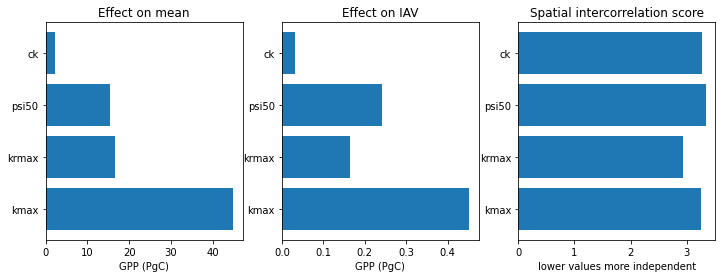

In [90]:
plt.figure(figsize=[12,4])
plt.subplot(131)
plt.barh(range(4),mean)
plt.yticks(range(4),uniques)
plt.xlabel('GPP (PgC)')
plt.title('Effect on mean');

plt.subplot(132)
plt.barh(range(4),iav)
plt.yticks(range(4),uniques)
plt.xlabel('GPP (PgC)')
plt.title('Effect on IAV');

plt.subplot(133)
plt.barh(range(4),spatial)
plt.yticks(range(4),uniques)
plt.xlabel('lower values more independent')
plt.title('Spatial intercorrelation score');